## Tabular Playground Series 01-2022



*In this notebook, we work on the Tabular Playground Series 01-2022 dataset from Kaggle website which is a time series prediction dataset in which we are going to predict the sales of two fictitious kaggle stores in different countries and predict which store sells better in the future*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
%matplotlib inline

In [3]:
train_df = pd.read_csv(r'train.csv') 
test_df = pd.read_csv(r'test.csv')




In [5]:
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date']  = pd.to_datetime(test_df['date'])

*We do some EDA on the train dataset and find the sales based on date as index*

In [5]:
train_date = train_df.set_index('date').pivot(columns=['country','store','product'],values='num_sold')
train_date.head()

country       Finland                                                  \
store      KaggleMart                           KaggleRama              
product    Kaggle Mug Kaggle Hat Kaggle Sticker Kaggle Mug Kaggle Hat   
date                                                                    
2015-01-01        329        520            146        572        911   
2015-01-02        318        493            127        544        794   
2015-01-03        360        535            141        579        843   
2015-01-04        332        544            125        582        873   
2015-01-05        243        378            102        423        668   

country                       Norway                                       \
store                     KaggleMart                           KaggleRama   
product    Kaggle Sticker Kaggle Mug Kaggle Hat Kaggle Sticker Kaggle Mug   
date                                                                        
2015-01-01            283        526        906            250       1005   
2015-01-02            249        538        845            237        949   
2015-01-03            265        614        930            254       1029   
2015-01-04            245        589        889            255        957   
2015-01-05            187        435        671            184        739   

country                                  Sweden                            \
store                                KaggleMart                             
product    Kaggle Hat Kaggle Sticker Kaggle Mug Kaggle Hat Kaggle Sticker   
date                                                                        
2015-01-01       1461            395        440        624            175   
2015-01-02       1446            415        384        572            155   
2015-01-03       1631            451        420        630            173   
2015-01-04       1540            455        406        697            169   
2015-01-05       1126            310        298        442            127   

country                                          
store      KaggleRama                            
product    Kaggle Mug Kaggle Hat Kaggle Sticker  
date                                             
2015-01-01        706       1195            324  
2015-01-02        653        986            293  
2015-01-03        734       1167            319  
2015-01-04        657       1112            300  
2015-01-05        512        796            227

In [6]:
train_month = train_df.set_index('date').groupby([pd.Grouper(freq='M'),'country','store','product'])['num_sold'].mean().unstack([1,2,3])


*We get the details of monthly products sold over all the data and plot the data as shown below*

Text(0, 0.5, 'numbers sold')

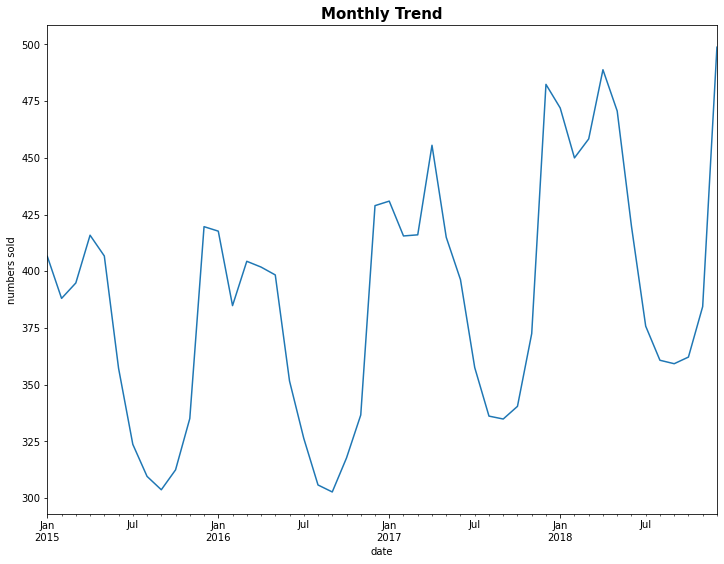

In [6]:
fig,ax = plt.subplots(1,1,figsize=(12,9))
train_df.set_index('date').groupby([pd.Grouper(freq='M')])['num_sold'].mean().plot(ax=ax)
ax.set_title('Monthly Trend',fontsize=15, fontweight='bold')
plt.ylabel('numbers sold')

*We can see from above plot the sales have fallen in around september month of every year and sales were highest around the months of December, January and March months*

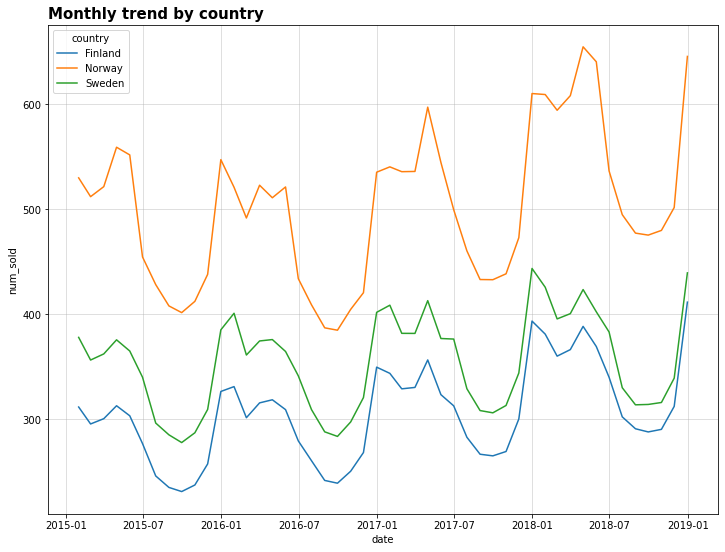

In [8]:
fig, ax = plt.subplots(1,1,figsize=(12,9))
train_month_country = train_df.set_index('date').groupby([pd.Grouper(freq='M'),'country'])[['num_sold']].mean()
sns.lineplot(x='date',y='num_sold', hue='country', data=train_month_country,ax=ax)
ax.set_ylabel('num_sold')
ax.set_title('Monthly trend by country', fontsize=15, fontweight='bold',loc='left')
ax.grid(alpha=0.5)
plt.show()

*From above plot we see that the numbers sold are highest  in **Norway** and least in **Finland**  countries*

*We extract the **days,months, weeks, years, weekend, dayofweek** features from below function*

In [7]:
#feature engineering

def feature_engineering(df):
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['dayofweek'] = df['date'].dt.dayofweek
    df['year'] = df['date'].dt.year
    df = pd.get_dummies(df)
    df['weekend'] = df['dayofweek'].apply(lambda x:x>=5)
    df['weekend']  = df['weekend'].map({False:0,True:1})
    
    return df

In [8]:
train = feature_engineering(train_df)
test = feature_engineering(test_df)


*Datasets are scaled using the below function*

In [11]:
def df_scaled(df):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    return df_scaled



*dropping target and row ids from train and test sets*

In [9]:

y = train['num_sold']
train.drop(columns=['row_id','date','num_sold'],inplace=True)
test_ids = test['row_id']
test.drop(columns=['row_id','date'],inplace=True)
test = test[train.columns]

*scaling the test and train datasets*

In [12]:
#

train_scaled = pd.DataFrame(df_scaled(train))
test_scaled = pd.DataFrame(df_scaled(test))

*We use CatboostRegressor model which is based on decision trees and gradient boosting. The main idea of boosting is to sequentially combine many weak models (a model performing slightly better than random chance) and thus through greedy search create a strong competitive predictive model*

*We use TimeSeriesSplit() to split our training dataset into train and test sets so that the dates of test sets are always after the end of the train sets.*
*We then perform the training on each fold based on the **CatboostRegressor()** and find the best iteration for the model*

In [13]:
#CatboostRegressor using TimeSeriesSplit for time series 
folds = TimeSeriesSplit(6)
y_predict = np.zeros(len(test_scaled))


for fold, (train_id, test_id) in enumerate(folds.split(train_scaled)):
    print("Fold: ", fold)
    
    X_train, y_train = train_scaled.iloc[train_id], y.iloc[train_id]
    X_valid, y_valid = train_scaled.iloc[test_id], y.iloc[test_id]
    
    
    # Model with parameters
    params = {
        'eval_metric': 'SMAPE',
        'iterations': 10000,
    }
    
    cat = CatBoostRegressor(**params)
    
    cat.fit(
        X_train, y_train, 
        eval_set=(X_valid, y_valid),
        early_stopping_rounds=2000,
        verbose=1000
    )
    
    print('\n')
    
    # Evaluation
    valid_pred = cat.predict(X_valid)
   
    
    # Prediction for submission
    y_predict += cat.predict(test_scaled) / folds.n_splits

Fold:  0
Learning rate set to 0.01539
0:	learn: 55.1370992	test: 51.3892196	best: 51.3892196 (0)	total: 178ms	remaining: 29m 43s
1000:	learn: 4.3116035	test: 12.7951962	best: 12.7706956 (803)	total: 1.6s	remaining: 14.4s
2000:	learn: 3.8226254	test: 12.7339003	best: 12.7339003 (2000)	total: 3.03s	remaining: 12.1s
3000:	learn: 3.5480968	test: 12.7379627	best: 12.7303965 (2267)	total: 4.36s	remaining: 10.2s
4000:	learn: 3.3526439	test: 12.7578046	best: 12.7303965 (2267)	total: 5.82s	remaining: 8.73s
Stopped by overfitting detector  (2000 iterations wait)

bestTest = 12.7303965
bestIteration = 2267

Shrink model to first 2268 iterations.


Fold:  1
Learning rate set to 0.017157
0:	learn: 52.3597386	test: 53.5020696	best: 53.5020696 (0)	total: 2.03ms	remaining: 20.3s
1000:	learn: 4.5076265	test: 7.0894090	best: 7.0172926 (564)	total: 1.57s	remaining: 14.1s
2000:	learn: 4.0888426	test: 7.2091357	best: 7.0172926 (564)	total: 3.17s	remaining: 12.7s
Stopped by overfitting detector  (2000 itera

In [21]:
a = np.column_stack([test_ids.astype(np.int32),y_predict])
df_csv = pd.DataFrame(a,columns=['row_id','num_sold'])
df_csv["row_id"] = df_csv["row_id"].astype(int)
df_csv.to_csv('tps_1_2022.csv',index=False)

*After submitting the predictions after trying out several hyperparameters we got a loss of just around 8*